# **Talleres de Capacitacion Bases de Datos dinamicas**





Para que el programa funcione correctamente hay que ir corriendo **secuencialmente**.

In [ ]:

!pip install geopandas;
#instalacion de geopandas
#GeoPandas es una librería  para trabajar con datos geoespaciales. Permite leer
#escribir, manipular y analizar datos geoespaciales en un formato  amigable.
!pip install windrose
# para plotear los graficos en direccional 




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 20.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Mount google Drive**

---


Motamos el Google Drive como disco de almacenamiento

In [1]:
from google.colab import drive
drive.mount('/content/drive')
#Montamos Google Drive como si fuese un disco duro

Mounted at /content/drive


**IMPORTING THE LIBRARIES**

---


In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import sys
import glob
import natsort
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import natsort
import glob
import os
import xarray as xr

from plotly.offline import plot

from windrose.windrose import WindroseAxes
from shapely.affinity import affine_transform as T
from shapely.affinity import rotate as R
import shapely.geometry
#importacion de todas las librerias externas necesarias

**IMPORTING THE LOCAL FUNCTIONS**



In [ ]:
sys.path.append('/content/drive/MyDrive/Panama2023')
import panama_fun as pnm
#libreria con todo el codigo adicional necesario

**SCRIPT**


## Aqui se ejecuta todo 





`plot the coastline and all the available nodes`

In [ ]:
filePath = '/content/drive/MyDrive/Panama2023';
df_costeros = pd.read_table(filePath + '/puntos_costeros.txt', delimiter = '  ', names = ['lon','lat','dpt']);
# La variable 'filePath' es la ruta al archivo que se va a leer
# Se utiliza '\t' como delimitador porque parece que el archivo utiliza tabulaciones en lugar de espacios
# Se proporciona el nombre de las columnas para el DataFrame: 'lon', 'lat' y 'dpt'

<ipython-input-6-ff78f937123a>:2: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.



Se va a mostrar un DataFrame con todos los valores que hay.
Se pueden buscar resultados con los filtros. 


In [ ]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

In [ ]:
df_costeros
# Mostrar el contenido del DataFrame


,lon,lat,dpt
0,-82.365260,9.448640,12.49222
1,-82.356720,9.442540,11.98437
2,-82.346630,9.444490,14.59276
3,-82.342960,9.436680,12.71609
4,-82.331980,9.445050,12.71130
...,...,...,...
1449,-77.989710,7.272695,162.27725
1450,-77.968869,7.253558,205.57796
1451,-77.946897,7.234349,246.14891
1452,-77.923396,7.216702,403.31494


Se han seleccionado 1454 puntos a lo largo de la costa panameña, con una resolución aproximada de ~2 km. En dichos puntos, se cuenta con las series temporales horarias de oleaje y nivel del mar en formato de texto y diferentes datos geoespaciales de climatologías y del índice de Nivel de Agua Total. A continuación, se representa la localización de dichos puntos, con la paleta de colores indicando la profundidad de los mismos.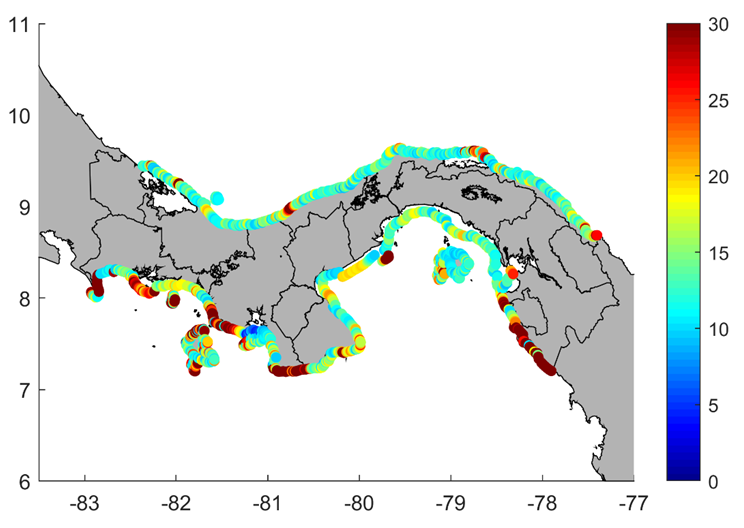

In [ ]:
# La función scatter_mapbox de Plotly Express se utiliza para crear un gráfico de dispersión georreferenciado
# El argumento 'lat' especifica los valores de latitud de los puntos
# El argumento 'lon' especifica los valores de longitud de los puntos
# El argumento 'color' especifica el color de los puntos en función de la columna 'dpt' del DataFrame
# La función update_layout se utiliza para ajustar el diseño del mapa
# El argumento 'mapbox' especifica el estilo del mapa. En este caso, se utiliza el estilo "carto-positron"
fig_cost = px.scatter_mapbox(lat=df_costeros['lat'], lon=df_costeros['lon'], color=df_costeros['dpt'], range_color  = [0,30], labels = {'color':'depth [m]'}).update_layout(mapbox={"style": "carto-positron", "zoom": 5})
# La función show se utiliza para mostrar el gráfico en la salida del Notebook

fig_cost.show()

# t = px.scatter_mapbox(lat=daCont.lat[0:ttsite], lon=daCont.lon[0:ttsite], color=varNfamCont_str[0:ttsite],\
#             size = np.ones(len(varNfamCont_str[0:ttsite]))*7,size_max = 7, opacity = 0.85,\
#                 color_discrete_map = dict(itertools.islice(color_discr_7.items(),\
#                                     int(varNfamCont['Nfam_%0.0f' %thesEn_perc][0:ttsite].max().data))),
#                 # hover_data={'species':False, # remove species from hover data
#                 #              'sepal_length':':.2f', # customize hover for column of y attribute
#                 #              'petal_width':True, # add other column, default formatting
#                 #              'sepal_width':':.2f', # add other column, customized formatting
#                 #              # data not in dataframe, default formatting
#                 #              'suppl_1': np.random.random(len(df)),
#                 #              # data not in dataframe, customized formatting
#                 #              'suppl_2': (':.3f', np.random.random(len(df)))
#                 #             }
#                   ).update_layout(mapbox={"style": "carto-positron"})
    

De todos ellos, se ha seleccionado un punto costero frente a la costa de la provincia de los Santos, en el litoral Pacífico panameño. En concreto, el punto 965 con coordenadas [-80.5835º,7.2209º].
 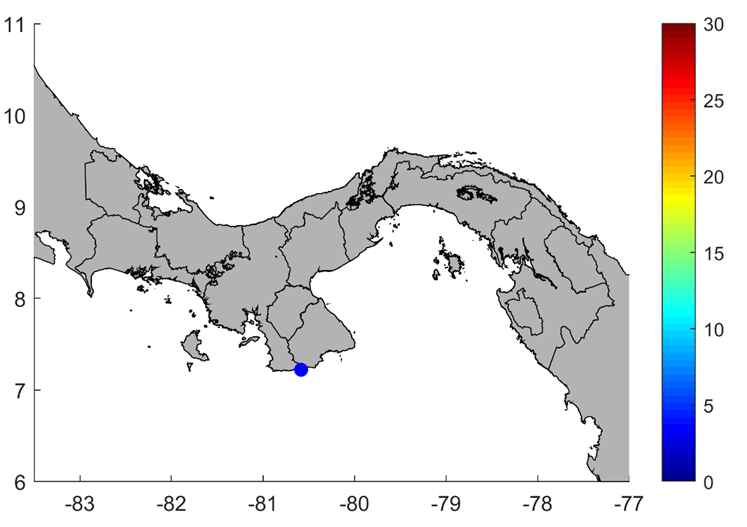


In [ ]:
# La variable 'filePath' es la ruta del directorio que contiene los archivos de texto
# La función glob se utiliza para encontrar todos los archivos que terminan en '.txt' en el directorio especificado
# Los resultados se almacenan en una lista
files = natsort.natsorted(glob.glob(filePath +'/ficheros_txt/*.txt.gz'))

In [ ]:
files

['/content/drive/MyDrive/Panama2023/ficheros_txt/Punto_0001_[9.44864][-82.3653].txt.gz',
 '/content/drive/MyDrive/Panama2023/ficheros_txt/Punto_0002_[9.44254][-82.3567].txt.gz',
 '/content/drive/MyDrive/Panama2023/ficheros_txt/Punto_0003_[9.44449][-82.3466].txt.gz',
 '/content/drive/MyDrive/Panama2023/ficheros_txt/Punto_0004_[9.43668][-82.343].txt.gz',
 '/content/drive/MyDrive/Panama2023/ficheros_txt/Punto_0005_[9.44505][-82.332].txt.gz',
 '/content/drive/MyDrive/Panama2023/ficheros_txt/Punto_0006_[9.44742][-82.3137].txt.gz',
 '/content/drive/MyDrive/Panama2023/ficheros_txt/Punto_0007_[9.45128][-82.3043].txt.gz',
 '/content/drive/MyDrive/Panama2023/ficheros_txt/Punto_0008_[9.4482][-82.2911].txt.gz',
 '/content/drive/MyDrive/Panama2023/ficheros_txt/Punto_0009_[9.44318][-82.287].txt.gz',
 '/content/drive/MyDrive/Panama2023/ficheros_txt/Punto_0010_[9.44855][-82.2743].txt.gz',
 '/content/drive/MyDrive/Panama2023/ficheros_txt/Punto_0011_[9.44219][-82.2729].txt.gz',
 '/content/drive/MyDrive/

In [ ]:
# La variable 'files' es una lista de nombres de archivo obtenidos previamente utilizando glob y natsort
# La función read_txt de la librería pnm se utiliza para leer el primer archivo de la lista
# El resultado se almacena en un objeto DataFrame
df = pnm.read_txt(files[0])

In [ ]:
df

,yyyy,mm,dd,hh,hs,tm02,tp,dir,nivel,marea,Datetime
0,1993,1,1,0,1.089,6.372,7.358,29.772,-0.021,0.002,1993-01-01 00:00:00
1,1993,1,1,1,1.074,6.349,7.358,29.868,-0.047,-0.015,1993-01-01 01:00:00
2,1993,1,1,2,1.058,6.326,7.358,30.005,-0.064,-0.041,1993-01-01 02:00:00
3,1993,1,1,3,1.042,6.301,7.358,30.192,-0.103,-0.070,1993-01-01 03:00:00
4,1993,1,1,4,1.025,6.275,7.358,30.436,-0.111,-0.090,1993-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...
254203,2021,12,31,19,1.315,7.196,8.851,40.034,-0.050,0.020,2021-12-31 19:00:00
254204,2021,12,31,20,1.319,7.192,8.851,39.972,-0.117,-0.050,2021-12-31 20:00:00
254205,2021,12,31,21,1.322,7.185,8.851,39.913,-0.174,-0.102,2021-12-31 21:00:00
254206,2021,12,31,22,1.324,7.177,8.851,39.855,-0.207,-0.134,2021-12-31 22:00:00


In [ ]:
# Datos de ejemplo
latitudes = [7.2209]
longitudes = [-80.5835]
profundidades = [33.68]

# Crea una figura con un mapa de fondo
fig = go.Figure(go.Scattermapbox(lat=latitudes, lon=longitudes, mode='markers',
                                  marker=dict(size=10, color=profundidades, colorscale='jet'),
                                  text=['Profundidad: {}'.format(p) for p in profundidades],
                                  hoverinfo='text'))

# Configura el diseño del mapa
fig.update_layout(mapbox_style='stamen-terrain', mapbox_zoom=10, mapbox_center=dict(lat=latitudes[0], lon=longitudes[0]))

# Muestra la figura
fig.show()



Se representa la serie temporal desde 1993-2021 de todas las variables de oleaje y de nivel, por separado.

In [ ]:
# La función line de Plotly Express se utiliza para crear un gráfico de línea
# El argumento 'x' especifica la columna 'Datetime' del DataFrame para el eje x
# El argumento 'y' especifica la columna 'hs' del DataFrame para el eje y
fig = px.line(df, x='Datetime', y="hs")
# La función update_layout se utiliza para ajustar el diseño del gráfico
# El argumento 'yaxis_range' especifica el rango del eje y, limitándolo entre 0 y 3
fig.update_layout(yaxis_range=[0,5])
# La función show se utiliza para mostrar el gráfico en la salida del Notebook
fig.show()

In [ ]:
# La función line de Plotly Express se utiliza para crear un gráfico de línea
# El argumento 'x' especifica la columna 'Datetime' del DataFrame para el eje x
# El argumento 'y' especifica la columna 'hs' del DataFrame para el eje y
fig = px.line(df, x='Datetime', y="tm02")
# La función update_layout se utiliza para ajustar el diseño del gráfico
# El argumento 'yaxis_range' especifica el rango del eje y, limitándolo entre 0 y 16
fig.update_layout(yaxis_range=[0,16])
# La función show se utiliza para mostrar el gráfico en la salida del Notebook
fig.show()

In [ ]:
# La función line de Plotly Express se utiliza para crear un gráfico de línea
# El argumento 'x' especifica la columna 'Datetime' del DataFrame para el eje x
# El argumento 'y' especifica la columna 'hs' del DataFrame para el eje y
fig = px.line(df, x='Datetime', y="tp")
# La función update_layout se utiliza para ajustar el diseño del gráfico
# El argumento 'yaxis_range' especifica el rango del eje y, limitándolo entre 0 y 3
fig.update_layout(yaxis_range=[0,21])
# La función show se utiliza para mostrar el gráfico en la salida del Notebook
fig.show()

In [ ]:
# La función line de Plotly Express se utiliza para crear un gráfico de línea
# El argumento 'x' especifica la columna 'Datetime' del DataFrame para el eje x
# El argumento 'y' especifica la columna 'hs' del DataFrame para el eje y
fig = px.line(df, x='Datetime', y="dir")
# La función update_layout se utiliza para ajustar el diseño del gráfico
# El argumento 'yaxis_range' especifica el rango del eje y, limitándolo entre 0 y 3
fig.update_layout(yaxis_range=[0,360])
# La función show se utiliza para mostrar el gráfico en la salida del Notebook
fig.show()

In [ ]:
# La función line de Plotly Express se utiliza para crear un gráfico de línea
# El argumento 'x' especifica la columna 'Datetime' del DataFrame para el eje x
# El argumento 'y' especifica la columna 'hs' del DataFrame para el eje y
fig = px.line(df, x='Datetime', y="nivel")
# La función update_layout se utiliza para ajustar el diseño del gráfico
# El argumento 'yaxis_range' especifica el rango del eje y, limitándolo entre 0 y 3
fig.update_layout(yaxis_range=[0,3])
# La función show se utiliza para mostrar el gráfico en la salida del Notebook
fig.show()

In [ ]:
# La función line de Plotly Express se utiliza para crear un gráfico de línea
# El argumento 'x' especifica la columna 'Datetime' del DataFrame para el eje x
# El argumento 'y' especifica la columna 'hs' del DataFrame para el eje y
fig = px.line(df, x='Datetime', y="marea")
# La función update_layout se utiliza para ajustar el diseño del gráfico
# El argumento 'yaxis_range' especifica el rango del eje y, limitándolo entre 0 y 3
# fig.update_layout(yaxis_range=[-3,3])
# La función show se utiliza para mostrar el gráfico en la salida del Notebook
fig.show()

# La función line de Plotly Express se utiliza para crear un gráfico de línea
# El argumento 'x' especifica la columna 'Datetime' del DataFrame para el eje x
# El argumento 'y' especifica la columna 'hs' del DataFrame para el eje y
fig2 = px.line(df, x='Datetime', y="hs")
# La función update_layout se utiliza para ajustar el diseño del gráfico
# El argumento 'yaxis_range' especifica el rango del eje y, limitándolo entre 0 y 3
# fig.update_layout(yaxis_range=[-3,3])
# La función show se utiliza para mostrar el gráfico en la salida del Notebook
fig2.show()

A continuación, seleccionamos el año 2015 para observar las condiciones de oleaje y nivel durante ese año. Por un lado, se trata de un año de El Niño, por lo que es interesante observar el comportamiento de la variable “residuo no meteorológico” durante ese año. Por otro lado, entre el 27 de abril y el 5 de mayo de 2015 se produjo un fuerte evento de inundación causado por fuertes oleajes que afectaron a toda la costa pacífico de Centroamérica. Marcamos ese evento en nuestros gráficos para observar el comportamiento de las distintas variables.

In [ ]:
df['hs'].loc[df['Datetime'] == '1993-01-01 01:00:00']

Seleccionar las fechas

In [ ]:
startDate = '2015-04-27 01:00:00'
endDate = '2015-05-05 01:00:00'
df['hs'].loc[(df['Datetime'] >= startDate) & (df['Datetime'] <= endDate)]

In [ ]:
# Selecciona los datos entre las fechas especificadas
startDate = '1993-01-01'
endDate = '2021-12-31'
df_subset = df.loc[(df['Datetime'] >= startDate) & (df['Datetime'] <= endDate)]

# Selecciona los datos dentro del intervalo de fechas a resaltar
highlight_startDate = '2015-04-27'
highlight_endDate = '2015-05-05'
df_highlight = df_subset.loc[(df_subset['Datetime'] >= highlight_startDate) & (df_subset['Datetime'] <= highlight_endDate)]

# Crea una figura
fig = go.Figure()

# Agrega una serie de datos para el intervalo de fechas a resaltar
fig.add_trace(go.Scatter(x=df_highlight['Datetime'], y=df_highlight['hs'], mode='lines', line=dict(color='red', width=3), name='El Niño'))

# Agrega una serie de datos para los datos fuera del intervalo de fechas a resaltar
fig.add_trace(go.Scatter(x=df['Datetime'], y=df['hs'], mode='lines', line=dict(color='blue', width=1), name = 'hs'))

# Personaliza el gráfico
fig.update_layout(title='Altura de ola significante {} y {}'.format(startDate, endDate),
                  xaxis_title='Fecha', yaxis_title='Altura de ola significante [m]')

# Muestra el gráfico
fig.show()


Por último, representamos un mes de marea astronómica (el mes de marzo de 2015) para observar su comportamiento. Se distinguen dos picos y dos valles por día, que corresponde con una marea de tipo semidiurno. Se observa que la amplitud de la marea astronómica oscila entre 0.75 m y 2.1 m, que coincide con las fases lunares de cuarto menguante/creciente y luna llena/nueva, respectivamente.

In [ ]:
# Selecciona los datos entre las fechas especificadas
startDate = '2015-03-01'
endDate = '2015-03-31'
df_subset = df.loc[(df['Datetime'] >= startDate) & (df['Datetime'] <= endDate)]

# Crea una figura
fig = go.Figure()

# Agrega una serie de datos para los datos fuera del intervalo de fechas a resaltar
fig.add_trace(go.Scatter(x=df_subset['Datetime'], y=df_subset['nivel'], mode='lines', line=dict(color='blue', width=1)))

# Personaliza el gráfico
fig.update_layout(title='Excursión de marea {} y {}'.format(startDate, endDate),
                  xaxis_title='Fecha', yaxis_title='Excursión de marea [m]')

# Muestra el gráfico
fig.show()


Histograma


## Rosa de Oleaje

In [ ]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 2, 1, projection="windrose")
title = 'Hs'
ax.set_title(title,fontdict = {'fontsize':20})

ax.bar(df['dir'],df['hs'], normed=True, opening=0.8, edgecolor='white',bins=np.arange(0, 2, 0.25), nsector = 30)
ax.legend(fontsize = 'x-large')

ax = fig.add_subplot(1, 2, 2, projection="windrose")
title = 'Tp'
ax.set_title(title,fontdict = {'fontsize':20})

ax.bar(df['dir'],df['tp'], normed=True, opening=0.8, edgecolor='white',bins=np.arange(0, 20, 2.5), nsector = 30)
ax.legend(fontsize = 'x-large')

plt.suptitle('Rosa de Oleaje', fontsize = 'xx-large')
plt.tight_layout()
plt.show()

##**NETCDF**

Vamos a trabajar con los ficheros mensuales en formato NetCDF de las 4 bases de datos (oleaje/nivel Caribe/Pacífico) del año 2016.

In [ ]:
netCdfFiles = pnm.list_dirs(os.path.join(filePath,"ficheros_netcdf"))

In [ ]:
pnm.plot_dpt_netcdf(filePath)

En primer lugar, extraemos la serie temporal de las variables de oleaje y nivel del mar durante el año 2016 en un punto frente a la costa de Colón, en el Caribe. En concreto, trabamos en el punto con coordenadas [-79.925406º, 9.513541º].

In [ ]:
olasC = pnm.get_temporal_series(netCdfFiles['OLAS']['CARIBE'])

In [ ]:
xr.__version__

'2022.12.0'

In [ ]:
olasC.attrs = {'title': 'Hindcast de oleaje, costa Caribe de Panamà'}
olasC

<xarray.Dataset>
Dimensions:  (nvert: 11999, time: 8784, ncell: 22460, numVert: 3)
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01 ... 2016-12-31T23:00:00.000003328
  * nvert    (nvert) int64 0 1 2 3 4 5 6 ... 11993 11994 11995 11996 11997 11998
Dimensions without coordinates: ncell, numVert
Data variables:
    lon      (nvert) float64 dask.array<chunksize=(11999,), meta=np.ndarray>
    lat      (nvert) float64 dask.array<chunksize=(11999,), meta=np.ndarray>
    z        (nvert) float64 dask.array<chunksize=(11999,), meta=np.ndarray>
    tri      (time, ncell, numVert) float64 dask.array<chunksize=(744, 22460, 3), meta=np.ndarray>
    hs       (nvert, time) float32 dask.array<chunksize=(11999, 744), meta=np.ndarray>
    tm02     (nvert, time) float32 dask.array<chunksize=(11999, 744), meta=np.ndarray>
    tp       (nvert, time) float32 dask.array<chunksize=(11999, 744), meta=np.ndarray>
    dir      (nvert, time) float32 dask.array<chunksize=(11999, 744), meta=np.ndarray>
    pdir     (nvert, time) float32 dask.array<chunksize=(11999, 744), meta=np.ndarray>
Attributes:
    title:    Hindcast de oleaje, costa Caribe de Panamà

In [ ]:
nivelC = pnm.get_temporal_series(netCdfFiles['NIVEL']['CARIBE'])

In [ ]:
import xarray as xr

In [ ]:
!pip install zmq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for zmq: filename=zmq-0.0.0-py3-none-any.whl size=1276 sha256=0c6375056b89cf75ad434accf8e6727fa7b47ad779c53c4aecab650c62b62bb7
  Stored in directory: /root/.cache/pip/wheels/5b/3b/c0/3521e7134b070e656ac26fea19d2110a88e351f0cb9b72e315
Successfully built zmq


In [ ]:
olasC

<xarray.Dataset>
Dimensions:  (nvert: 11999, time: 8784, ncell: 22460, numVert: 3)
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01 ... 2016-12-31T23:00:00.000003328
  * nvert    (nvert) int64 0 1 2 3 4 5 6 ... 11993 11994 11995 11996 11997 11998
Dimensions without coordinates: ncell, numVert
Data variables:
    lon      (nvert) float64 dask.array<chunksize=(11999,), meta=np.ndarray>
    lat      (nvert) float64 dask.array<chunksize=(11999,), meta=np.ndarray>
    z        (nvert) float64 dask.array<chunksize=(11999,), meta=np.ndarray>
    tri      (time, ncell, numVert) float64 dask.array<chunksize=(744, 22460, 3), meta=np.ndarray>
    hs       (nvert, time) float32 dask.array<chunksize=(11999, 744), meta=np.ndarray>
    tm02     (nvert, time) float32 dask.array<chunksize=(11999, 744), meta=np.ndarray>
    tp       (nvert, time) float32 dask.array<chunksize=(11999, 744), meta=np.ndarray>
    dir      (nvert, time) float32 dask.array<chunksize=(11999, 744), meta=np.ndarray>
    pdir     (nvert, time) float32 dask.array<chunksize=(11999, 744), meta=np.ndarray>
Attributes:
    title:    Hindcast de oleaje, costa Caribe de Panamà

In [ ]:
olasC_sel = pnm.sel_lonlat(olasC,lon = -79.925406,lat = 9.513541)
nivelC_sel = pnm.sel_lonlat(nivelC,lon = -79.925406,lat = 9.513541)

Se observa un máximo en la altura de ola en Noviembre de 2016, que coincide con el paso del huracán Otto. Este huracán se produjo entre el 17 y el 26 de noviembre. Lo representamos en nuestro gráfico para observar el comportamiento de las distintas variables:

In [ ]:
# FROM 17 TO 26 DEC
#------------Start la fecha--------
startDate = '2016-11-17T00:00:00'
endDate = '2016-11-27T00:00:00'

fig = go.Figure()
fig.add_trace(go.Scatter(x=olasC_sel['time'], y=olasC_sel['hs'],
                    mode='lines',
                    name='hs'))
fig.add_trace(go.Scatter(x = olasC_sel['time'].loc[dict(time=slice(startDate,endDate))],\
                         y = olasC_sel['hs'].loc[dict(time=slice(startDate,endDate))],
                    mode='lines',
                    name='Huracán Otto'))

fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=nivelC_sel['time'], y=nivelC_sel['level'],
                    mode='lines',
                    name='nivel'))
fig.add_trace(go.Scatter(x = nivelC_sel['time'].loc[dict(time=slice(startDate,endDate))],\
                         y = nivelC_sel['level'].loc[dict(time=slice(startDate,endDate))],
                    mode='lines',
                    name='Huracán Otto'))

fig.show()

En segundo lugar, vamos a representar la situación sinóptica correspondiente al paso del **huracán Otto**. Para ello, representamos el valor de las distintas variables de oleaje en un instante dado en todos los nodos de la malla numérica. En concreto, trabajamos con la fecha del **22 de Noviembre de 2016** a las 6:00h. representamos el valor de ola altura de ola, del periodo medio y la dirección del oleaje mediante flechas.

In [ ]:
t = px.scatter_mapbox(lat=olasC.lat, lon=olasC.lon, color=olasC['hs'].sel(time = '2016-11-22T06:00:00')[:,0], labels = {'color':'hs [m]'}, range_color = [0,3], title = 'Hs during Huracán Otto').update_layout(mapbox={"style": "carto-positron", "zoom":6})
t.show()

In [ ]:
pnm.quiver_map(olasC, step = 5)

Por último, vamos a representar un par de situaciones sinópticas del nivel del mar en la costa Pacífico, donde se observa condiciones de pleamar y bajamar, con una amplificación de la onda en el interior del Golfo de Panamá. En concreto, representamos los instantes del **3 de noviembre de 2016** a las **11:00h** y a las **17:00h**.


In [ ]:
nivelP = pnm.get_temporal_series(netCdfFiles['NIVEL']['PACIFICO'])

In [ ]:
t = px.scatter_mapbox(lat=nivelP.lat, lon=nivelP.lon, color=nivelP['level'].sel(time = '2016-11-03T11:00:00')[:,0], labels = {'color':'Nivel del mar [m]'}, range_color=[0,2]).update_layout(mapbox={"style": "carto-positron", "zoom":6})
t.show()

t2 = px.scatter_mapbox(lat=nivelP.lat, lon=nivelP.lon, color=nivelP['level'].sel(time = '2016-11-03T17:00:00')[:,0], labels = {'color':'Nivel del mar [m]'}, range_color= [-2,1]).update_layout(mapbox={"style": "carto-positron", "zoom":6})
plot(t2)